## Inicializacao

(1000, 2)


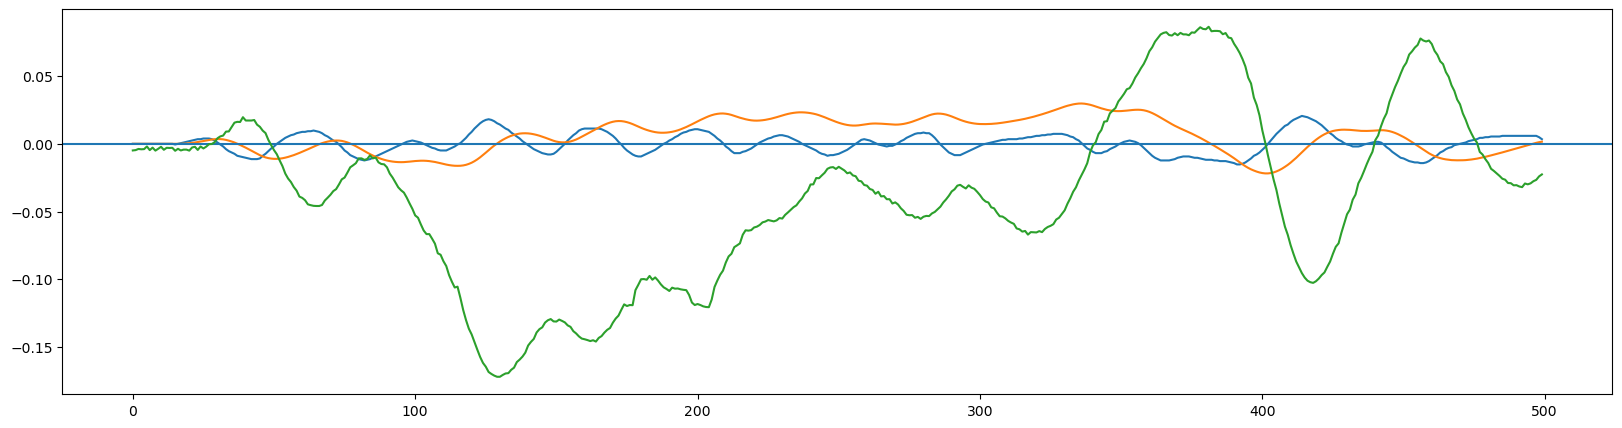

In [44]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.io as sc 
from scipy import signal
from sympy import symbols, pprint
import matplotlib.pyplot as plt
from structureSelector import *
from methods.utils.utilities import *

ballbeam  = np.loadtxt('data/ballbeam.dat')
print(ballbeam.shape)
part = ballbeam.shape[0] // 2#700

u = ballbeam[:part, 0].reshape((1,-1))
y = ballbeam[:part, 1].reshape((1,-1))

dd = 2

'''df = pd.DataFrame(u.T, columns=['A'])
un = df.rolling(dd).mean().values
un[:dd-1] = 0
u = un.T'''

'''df = pd.DataFrame(y.T, columns=['A'])
un = df.rolling(dd).mean().values
un[:dd-1] = 0
y = un.T'''

u[:, :15] = 0
#u[:, :20] = 0


'''y = y / 0.15
u = u / 0.02'''

U = np.zeros(u.shape)
U[0, 0] = u[0, 0] * 0.1
for i in range(1, u.shape[1]):
    U[0, i] = U[0, i-1] + u[0, i] * 0.1

u = np.vstack((u, U)) 

plt.figure(figsize=(20,5))
plt.plot(u[:, :].T)
#plt.plot(U.T)
plt.axhline(linewidth=0.5, color='r')
plt.axhline(y=0)
plt.plot(y[:,:].T)
plt.show()


def metrics(y, yest):
    residuo1 = y - yest
    mape = round(np.mean(np.abs(residuo1 / (yest + np.finfo(np.float64).eps))), 5)
    print('RMSE:', np.sqrt(np.mean(np.square(residuo1))), 'MSE:', np.mean(np.square(residuo1)), '\nAET:', np.sum(np.abs(residuo1)), '\nMAPE:', str(mape) + '%')
    cc = np.corrcoef(y, yest)
    #print("Correlation pearson:", np.mean(cc))


## Selecao de estrutura

[Y1.1 Y1.2 U1.12 U2.8] 0.185751429291341*U1.12 + 0.0574500133455228*U2.8 + 1.39592249114238*Y1.1 - 0.389576836221355*Y1.2
Simulação livre
--------s:  [Y1.1, Y1.2, U1.7, U1.8, U1.9, U1.10, U1.11, U1.12, U1.13, U1.14, U1.15, U2.7, U2.8, U2.9, U2.10, U2.11, U2.12, U2.13, U2.14, U2.15]

Simulação livre
RMSE: 0.04796114417806973 MSE: 0.002300271350869592 
AET: 17.829235732861633 
MAPE: 1.98432%

Um passo a frente
RMSE: 0.0019638371781119015 MSE: 3.856656462134516e-06 
AET: 0.7623159366506275 
MAPE: 0.13997%


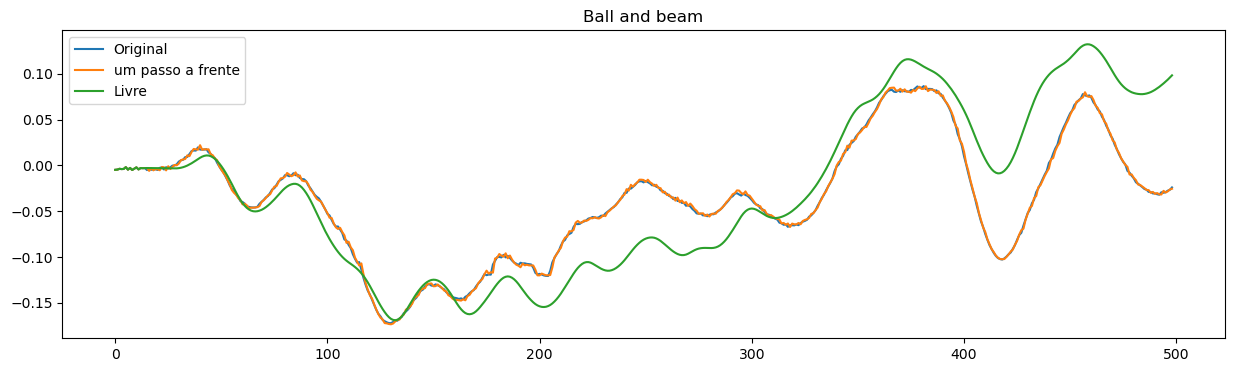

In [45]:
#Selecione o tanque 
output = 0  # 0 ou 1
num = [4]
params = []
#params.append({'nb':[2],'na':[10], 'level':3, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':1, 'diff':True})
#params.append({'nb':[2],'na':[20], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':2, 'diff':False})#n3
#params.append({'nb':[0],'na':[6], 'level':3, 'nonlinear':[1,1,0,0,0], 'root':False, 'delay':0, 'diff': False})
params.append({'nb':[2],'na':[15, 15], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':7, 'diff': False}) #best result

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output])
#print(ss)

vCandidatos = sselector.matrix_candidate(u, y, **params[output], dt=0.1)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, y[output, pad:], num[output], 0.000000001)

model = ss[selected]
#print(model, selected)

theta = LSM(y[output, pad:], psi)

model = ss[selected]
print(model, model @ theta)


slivre = sselector.predict(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)
yhat = sselector.oneStepForward(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=0.1)


print("\nSimulação livre")
metrics(y, slivre)
print("\nUm passo a frente")
metrics(y, yhat)

plt.figure(figsize=(15,4))
t = -1
s = 0#t-20
g = 105
plt.title("Ball and beam")

plt.plot(y[output, s:t].T, label='Original')
plt.plot(yhat[s:t], label='um passo a frente')
plt.plot(slivre[s:t], label='Livre')
plt.legend()
plt.show()

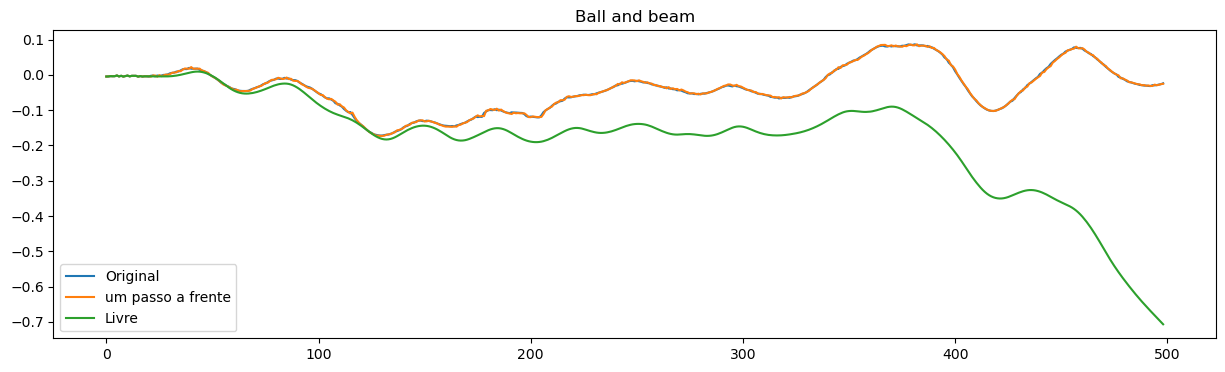

In [28]:
plt.figure(figsize=(15,4))
t = -1
s = 0#t-20
g = 105
plt.title("Ball and beam")

plt.plot(y[output, s:t].T, label='Original')
plt.plot(yhat[s:t], label='um passo a frente')
plt.plot(slivre[s:t], label='Livre')
plt.legend()
plt.show()

### Simulação

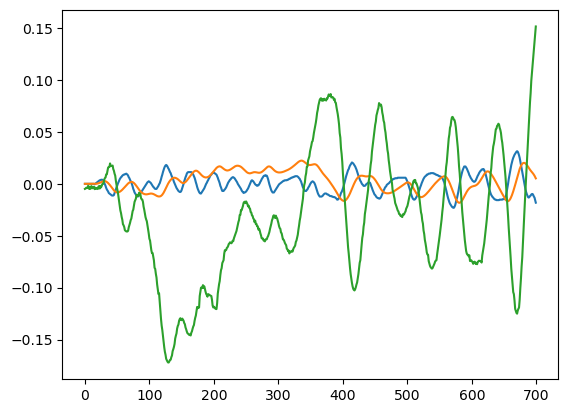

In [67]:
uVal = ballbeam[0:part+200, 0].reshape((1,-1))
yVal = ballbeam[0:part+200, 1].reshape((1,-1))# / 0.15

UVal = np.zeros(uVal.shape)
#UVal[0, 0] = u[1, -1] + 0.1 * uVal[0, 0]
for i in range(1, uVal.shape[1]):
    UVal[0, i] = UVal[0, i-1] + uVal[0, i] * 0.075

uVal = np.vstack((uVal, UVal)) 
#print(u[1, -1], uVal[1, 0])
plt.plot(uVal.T)
plt.plot(yVal.T)
plt.show()

Simulação livre
--------s:  [Y1.1, Y1.2, U1.7, U1.8, U1.9, U1.10, U1.11, U1.12, U1.13, U1.14, U1.15, U2.7, U2.8, U2.9, U2.10, U2.11, U2.12, U2.13, U2.14, U2.15]
Modelo selecionado:
0.185751429291341⋅U1.12 + 0.0574500133455228⋅U2.8 + 1.39592249114238⋅Y1.1 - 0.
389576836221355⋅Y1.2


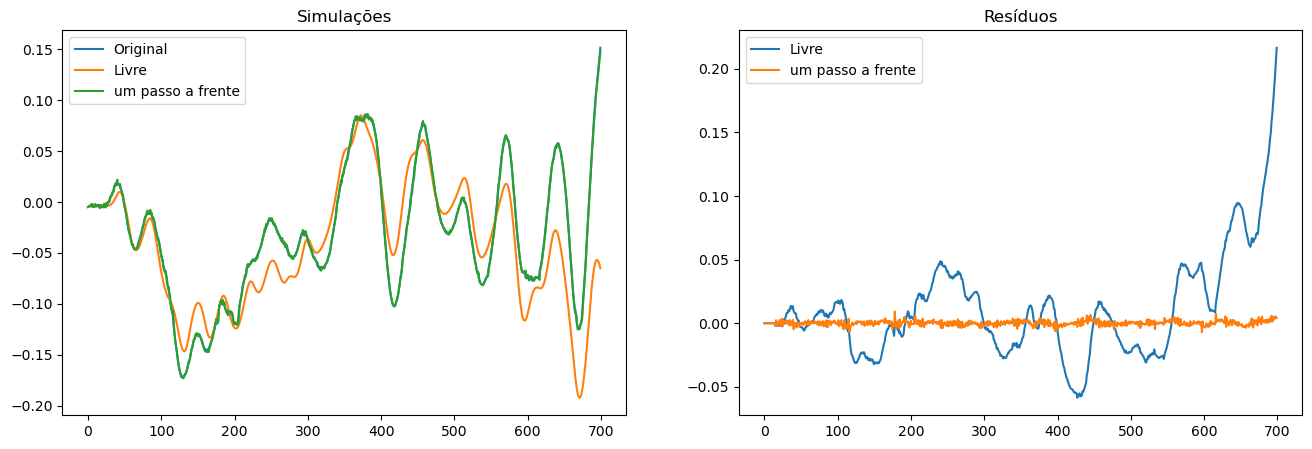

In [68]:
#uVal = UVal
valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)
yhat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=0.1)

print("Modelo selecionado:")
pprint( model @ theta)

f, ax = plt.subplots(1,2, figsize=[16,5])

ax[0].plot(yVal[output].T, label='Original')
ax[0].plot(valLivre, label='Livre')
ax[0].plot(yhat, label='um passo a frente')
ax[0].set_title("Simulações")
ax[0].legend()


ax[1].plot(yVal[output].T - valLivre, label='Livre')
ax[1].plot(yVal[output].T - yhat, label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()

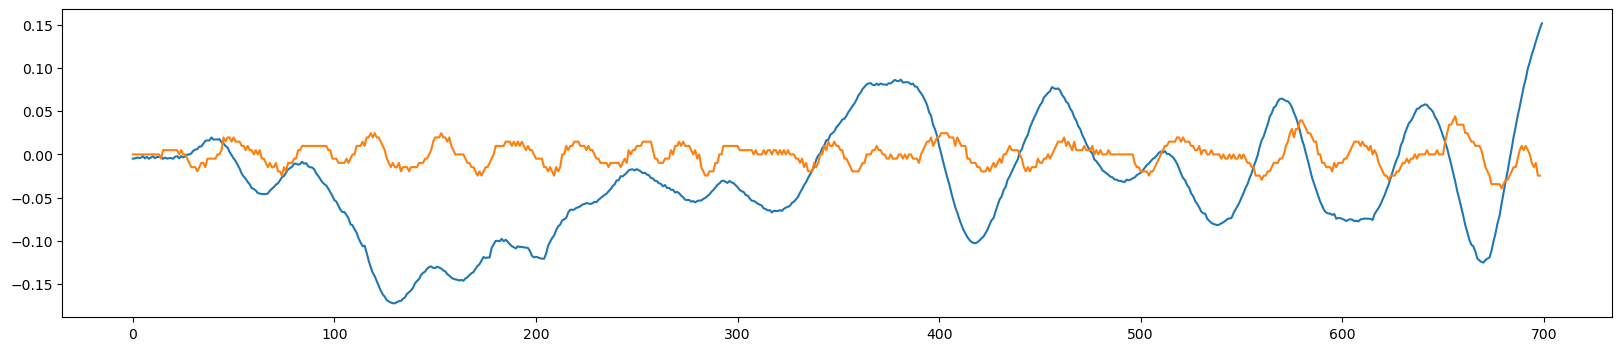

In [71]:
uc = UVal.copy()
uc[:, 120:] -= 0.02
uc[:, 375:] += 0.02
plt.figure(figsize=(20,4))
plt.plot(yVal.T)
plt.plot((uVal[0, 1:] - uVal[0, :-1]).T / 0.1)
#plt.plot(uc[:, :].T / 0.1)
plt.show()

## Teste

In [ ]:
du = np.zeros(u.shape)

du[:, 1:] = (u[:,1:] - u[:,:-1]) / 0.1
dy = np.zeros(y.shape)
dy[:, 1:] = (y[:,1:] - y[:,:-1]) / 0.1
d2y = np.zeros(y.shape)
d2y[:, 1:] = (dy[:,1:] - dy[:,:-1]) / 0.1
yy = np.zeros(y.shape)
ys = np.zeros(y.shape)
'''
for i in range(yy.shape[1]):
    yy[:, i] = y[:, i-1] * du[:, i-1]**2
'''
'''print(np.where(np.abs(du) < 0.001)[1])
index = np.where(np.abs(du) < 0.001)[1]
du[:, index] = np.sign(du[:,index]) * 0.001
print(np.where(np.abs(du) < 0.001)[1], du[:, :10])
w = (u / (du**2 / 0.001))
'''

w = np.zeros(y.shape)
v = np.zeros(y.shape)
last = 1
for i in range(yy.shape[1]):
    if np.abs(du[:, i]) > 0.001:
        last = du[:, i]**2 
        w[:, i] = (u[:, i] - 0.001) / (last / 0.001)
        v[:, i] = d2y[:, i] / (last / 0.0001)
    else:
        w[:, i] = u[:, i] / (last / 0.001)
        v[:, i] = d2y[:, i] / (last / 0.0001)

for i in range(1, yy.shape[1]):
    yy[:, i] = yy[:, i-1] + w[:, i-1] * 0.2 + v[:, i-1] * 0.5
    ys[:, i] = ys[:, i-1] + yy[:, i-1] + w[:, i-1] * 0

t = np.arange(0,50,0.1)
plt.figure(figsize=(15,4))
#plt.plot(w.T)
#plt.plot(yy.T * 0.1)
plt.plot(t[:], ys[:,:].T * 0.001)
plt.plot(t, y.T)
#plt.plot(v.T)
#plt.plot(du.T)
plt.show()
#print(np.where(np.abs(du) < 0.001)[1])